<a href="https://colab.research.google.com/github/Raghava2004-cpu/Predicting-the-Stock-Prices-using-the-GRU-Neura-networks/blob/main/Predicting_the_Stock_Prices_using_the_GRU_neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import yfinance as yf

stock_data = yf.download('MSFT' , start = '2024-01-01' , end = '2025-05-15')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2024-01-02,367.380585,372.363258,363.319154,370.342443,25258600
2024-01-03,367.113159,369.748136,365.042827,365.538123,23083500
2024-01-04,364.478180,369.589635,363.715435,367.182505,20901500
2024-01-05,364.289978,368.559424,363.051739,365.498501,20987000
2024-01-08,371.164673,371.669884,365.538121,365.825371,23134000


In [105]:
stock_data.to_csv("Microsoft stock data")
df =  pd.read_csv("Microsoft stock data")
df.dropna(inplace= True)
df = df[1:len(df)]
df.head()

,Price,Close,High,Low,Open,Volume
2,2024-01-02,367.3805847167969,372.3632576668665,363.3191544056819,370.3424429826701,25258600
3,2024-01-03,367.1131591796875,369.7481357898977,365.04282689247566,365.5381225658885,23083500
4,2024-01-04,364.4781799316406,369.5896348719219,363.71543548306664,367.1825051718643,20901500
5,2024-01-05,364.28997802734375,368.559424433647,363.0517388090319,365.4985007136341,20987000
6,2024-01-08,371.1646728515625,371.66988411040546,365.53812127674354,365.8253710003868,23134000


In [106]:
df.tail()

,Price,Close,High,Low,Open,Volume
340,2025-05-08,438.1700134277344,443.6700134277344,435.6600036621094,437.92999267578125,23491300
341,2025-05-09,438.7300109863281,440.739990234375,435.8800048828125,440.0,15324200
342,2025-05-12,449.260009765625,449.3699951171875,439.7799987792969,445.94000244140625,22821900
343,2025-05-13,449.1400146484375,450.6700134277344,445.3599853515625,447.7799987792969,23618800
344,2025-05-14,452.94000244140625,453.8999938964844,448.1400146484375,448.1400146484375,19870100


<Axes: xlabel='Date', ylabel='Share price USD($)'>

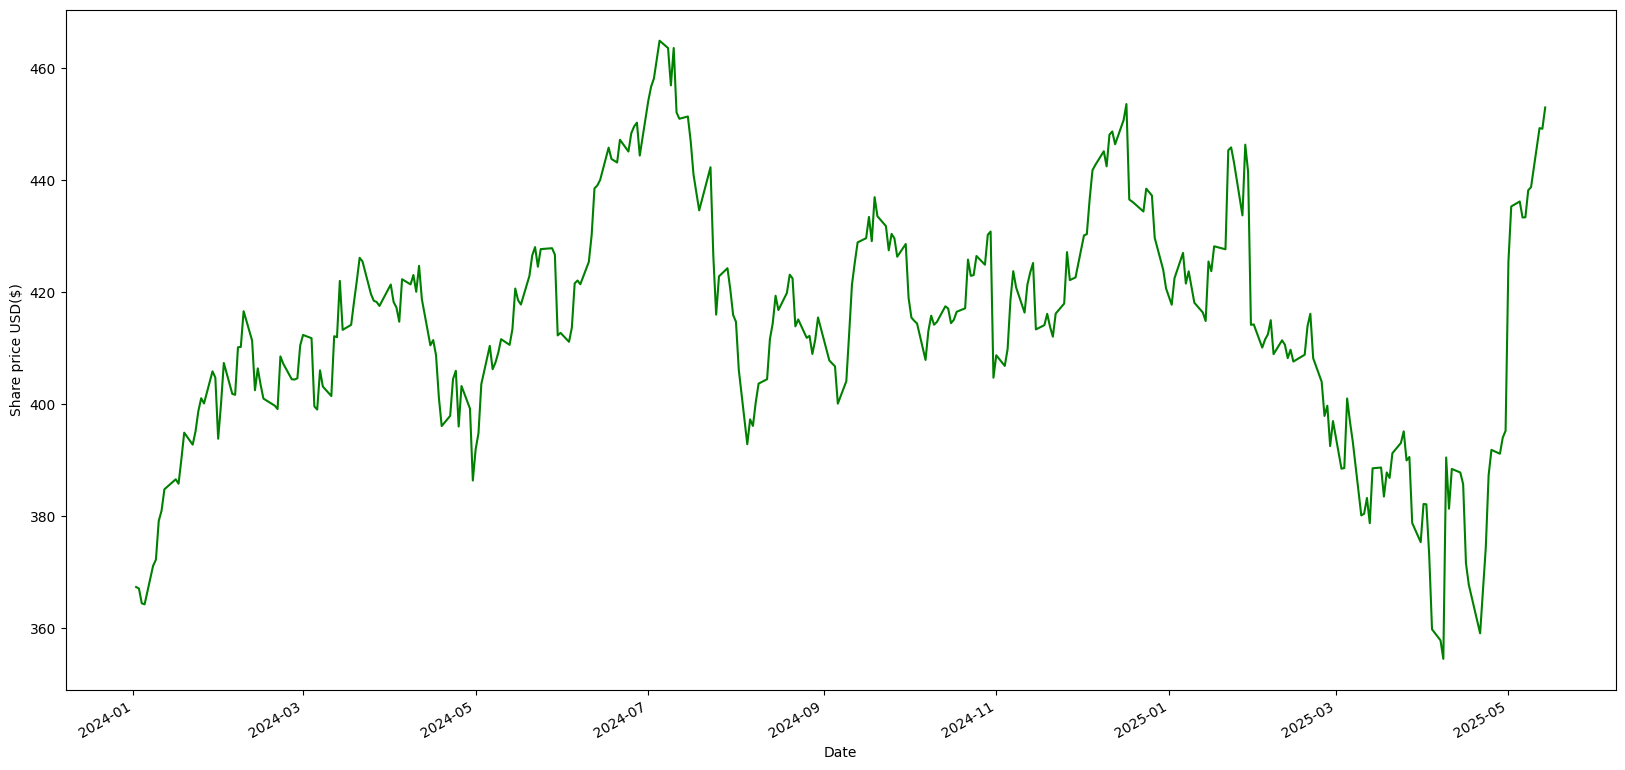

In [107]:
plt.ylabel('Share price USD($)')
stock_data[('Close' , 'MSFT')].plot(color = 'green' , figsize = (20,10))

In [108]:
scaler = MinMaxScaler(feature_range=(0,1))
closed_prices = df['Close'].values.reshape(-1,1)
scaled_closed_values = scaler.fit_transform(closed_prices)

seq_len = 20
def create_data(scaled_closed_values , seq_len):
    x , y= [] , []
    for i in range(len(scaled_closed_values) - seq_len):
        x.append(scaled_closed_values[i : i+seq_len])
        y.append(scaled_closed_values[i+seq_len])

    return np.array(x) , np.array(y)
x , y = create_data(scaled_closed_values , seq_len)
x = torch.FloatTensor(x)
y =  torch.FloatTensor(y)


class GRU(nn.Module):
    def __init__(self , input_size = 1 , hidden_size = 64 , output_size = 1 , num_layers = 2):
        super(GRU ,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size , hidden_size , num_layers , batch_first= True)
        self.fc =  nn.Linear(hidden_size , output_size)
    def forward(self , x):
        h0 = torch.zeros(self.num_layers , x.size(0) , self.hidden_size).to(device)
        out , _ = self.gru(x , h0)
        out =  self.fc(out[: , -1, :])

        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRU().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr = 0.01)


In [109]:
epochs = 100
model.train()
training_loss = []
for epoch in range(epochs+1):
    inputs  , targets = x.to(device) , y.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs , targets)
    loss.backward()
    optimizer.step()
    training_loss.append(loss.item())

    if epoch % 10 == 0:
        print(f"{epoch}/{epochs} , Loss : {loss.item()}")



0/100 , Loss : 0.2080841213464737
10/100 , Loss : 0.014804690144956112
20/100 , Loss : 0.00827537290751934
30/100 , Loss : 0.004523977637290955
40/100 , Loss : 0.003777212230488658
50/100 , Loss : 0.0033759651705622673
60/100 , Loss : 0.003232387127354741
70/100 , Loss : 0.0031911989208310843
80/100 , Loss : 0.003171249059960246
90/100 , Loss : 0.003156521590426564
100/100 , Loss : 0.0031437750440090895


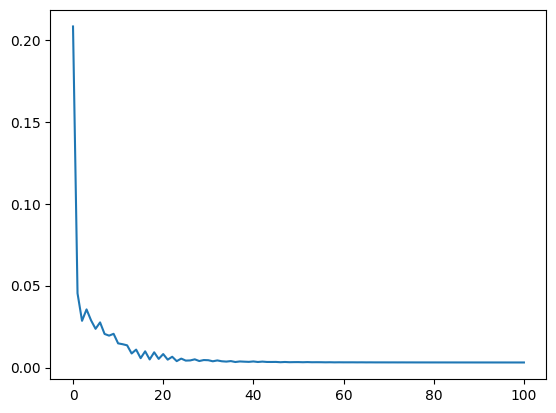

In [110]:
plt.plot(training_loss)

In [111]:
print(len(scaled_closed_values))

343


In [112]:
n_future = 11
last_seq = scaled_closed_values[323:343]
def future_predictions(model , last_seq , n_future , scaler , seq_len):
    model.eval()
    future_pred = []
    current_seq = last_seq
    with torch.no_grad():
      for _ in range(n_future):
        input_seq = torch.FloatTensor(current_seq).reshape(1,seq_len,1).to(device)
        pred = model(input_seq).cpu().numpy()
        future_pred.append(pred[0,0])
        current_seq = np.roll(current_seq , -1 , axis = 0)
        current_seq[-1] = pred[0,0]

    future_pred = np.array(future_pred).reshape(-1,1)
    return scaler.inverse_transform(future_pred)

predictions =     future_predictions(model , last_seq , n_future , scaler , seq_len)


In [115]:
print(f"These are the Predictions made by the model for the next 11 days : {predictions}")

These are the Predictions made by the model for the next 11 days : [[452.70126]
 [452.64395]
 [452.4457 ]
 [452.14685]
 [451.60876]
 [450.87735]
 [449.98428]
 [448.9436 ]
 [447.76837]
 [446.4905 ]
 [445.14227]]


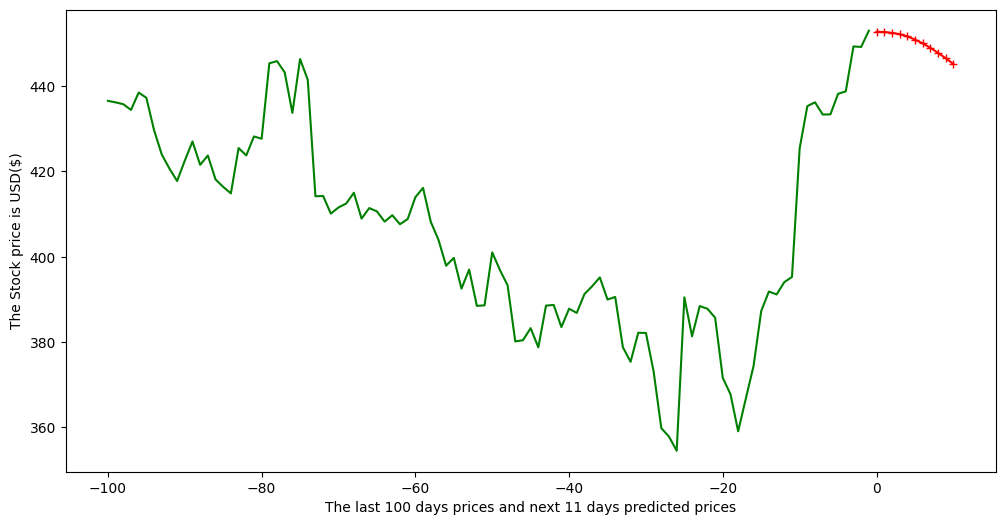

In [117]:
historical_prices = scaler.inverse_transform(scaled_closed_values[-100:])
plt.figure(figsize=(12, 6))
plt.xlabel("The last 100 days prices and next 11 days predicted prices")
plt.ylabel("The Stock price is USD($)")
plt.plot(range(-100, 0), historical_prices, label='Historical Prices' , color = 'green')
plt.plot(range(0, n_future), predictions, label='Predicted Prices', marker = '+' , color = 'red' )